# Tabular - Mutliclass Classification using DNNs
By [Akshaj Verma](https://akshajverma.com/)

This notebook takes you through the implementation of multiclass classification using feedforward networks on the [wine dataset](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009) using PyTorch.

We will use the wine dataset available on Kaggle. This dataset has 12 columns where the first 11 are the features and the last column is the target column. The data set has 1599 rows.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
torch.manual_seed(69)
np.random.seed(21)

In [3]:
%matplotlib inline
sns.set_style('darkgrid')

print("We're using cuda?", torch.cuda.is_available())

We're using cuda? True


In [4]:
df = pd.read_csv("../../../data/tabular/classification/winequality-red.csv")

## Pre-processing

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
print("Number of rows:", len(df))

Number of rows: 1599


In [7]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


First off, we plot the output rows to observe the class distribution. There's a lot of imbalance here. Classes 3, 4, and 8 have a very few number of samples.

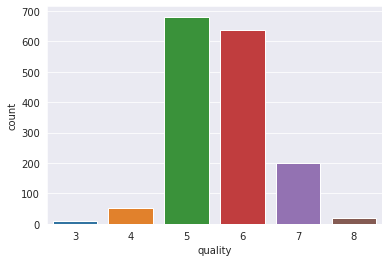

In [8]:
sns.countplot(x = 'quality', data=df)

Next, we see that the output labels are from 3 to 8. That needs to change because PyTorch supports labels starting from 0. That is [0, n]. We need to remap our labels to start from 0.


To do that, let's create a dictionary called class2idx  and use the .replace() method from the Pandas library to change it. Let's also create a reverse mapping called idx2class which converts the IDs back to their original classes.


To create the reverse mapping, we create a dictionary comprehension and simply reverse the key and value.

In [9]:
# PyTorch supports labels starting from 0. That is [0, n]. We need to remap our labels to start from 0.

class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

idx2class = {v: k for k, v in class2idx.items()}

df['quality'].replace(class2idx, inplace=True)

In order to split our data into train, validation, and test sets, we need to separate out our inputs and outputs. 


Input X is all but the last column. Output y is the last column.

In [10]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

## Train - Validation - Test

To create the train-val-test split, we'll use train_test_split() from Sklearn. 


First we'll split our data into train+val and test sets. Then, we'll further split our train+val set to create our train and val sets. 

Because there's a class imbalance, we want to have equal distribution of all output classes in our train, validation, and test sets. 

To do that, we use the stratify option in function train_test_split().

In [11]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

Neural networks need data that lies between the range of (0,1). There's a ton of material available online on why we need to do it. 

To scale our values, we'll use the `MinMaxScaler()` from Sklearn. The `MinMaxScaler` transforms features by scaling each feature to a given range which is (0,1) in our case.


> x_scaled = (x-min(x)) / (max(x)–min(x))


Notice that we use `.fit_transform()` on `X_train` while we use `.transform()` on `X_val` and `X_test` . 

We do this because we want to scale the validation and test set with the same parameters as that of the train set to avoid data leakage. `it_transform` calculates scaling values and applies them while `.transform` only applies the calculated values.

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [13]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

Once we've split our data into train, validation, and test sets, let's make sure the distribution of classes is equal in all three sets.

To do that, let's create a function called `get_class_distribution()`.   
This function takes as input the obj `y` , ie. `y_train`, `y_val`, or `y_test`. Inside the function, we initialize a dictionary which contains the output classes as keys and their count as values. The counts are all initialized to 0. 


We then loop through our `y` object and update our dictionary.

In [14]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict 

Once we have the dictionary count, we use Seaborn library to plot the bar charts. 

The make the plot, we first convert our dictionary to a dataframe using `pd.DataFrame.from_dict([get_class_distribution(y_train)])`. 

Subsequently, we `.melt()` our convert our dataframe into the long format and finally use `sns.barplot()` to build the plots.

In [15]:
print("Train:", get_class_distribution(y_train))
print("Test :", get_class_distribution(y_test))
print("Val  :", get_class_distribution(y_val))

Train: {'rating_3': 7, 'rating_4': 38, 'rating_5': 490, 'rating_6': 459, 'rating_7': 143, 'rating_8': 14}
Test : {'rating_3': 2, 'rating_4': 11, 'rating_5': 136, 'rating_6': 128, 'rating_7': 40, 'rating_8': 3}
Val  : {'rating_3': 1, 'rating_4': 4, 'rating_5': 55, 'rating_6': 51, 'rating_7': 16, 'rating_8': 1}


Text(0.5, 1.0, 'Class Distribution in Test Set')

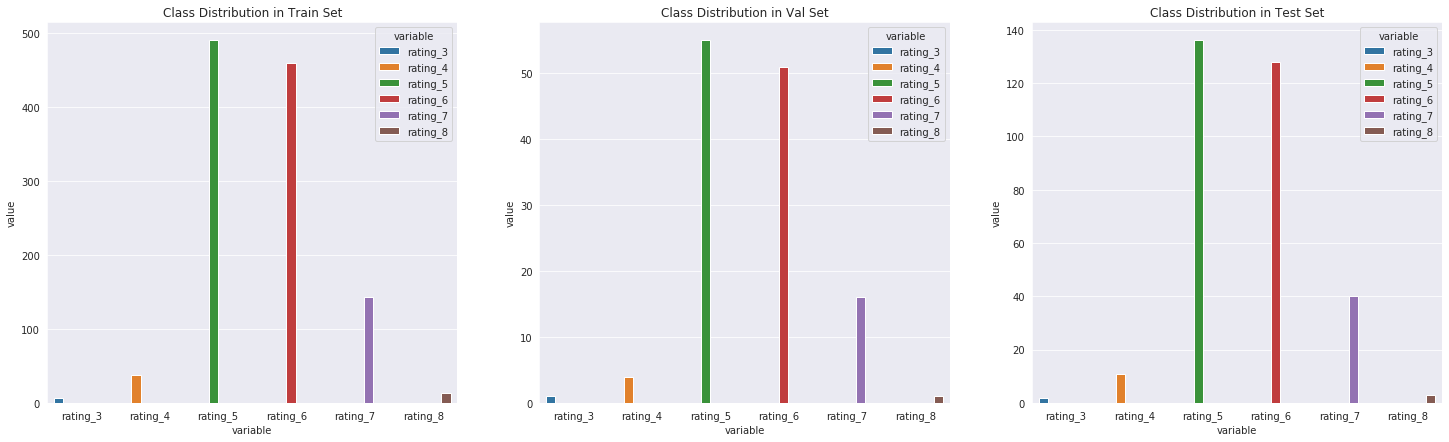

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

## Neural Net

### Define Custom Dataset

First up, let's define a custom dataset. This dataset will be used by the dataloader to pass our data into our model.   
We initialize our dataset by passing X and y as inputs. Make sure X is a `float` while y is `long`.

In [17]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

### Weighted Sampling

Because there's a class imbalance, we use stratified split to create our train, validation, and test sets.  

While it helps, it still does not ensure that each mini-batch of our model see's all our classes. We need to oversample the classes with less number of values. To do that, we use the `WeightedRandomSampler`.


First, we obtain a list called target_list which contains all our outputs. This list is then converted to a tensor and shuffled.

In [18]:
target_list = []

for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

Then, we obtain the count of all classes in our training set. We use the reciprocal of each count to obtain it's weight.   
Now that we've calculated the weights for each class, we can proceed.

In [19]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
class_weights

tensor([0.1429, 0.0263, 0.0020, 0.0022, 0.0070, 0.0714])

`WeightedRandomSampler` expects a weight for each sample. We do that using the following command.

In [20]:
class_weights_all = class_weights[target_list]

Finally, let's initialize our `WeightedRandomSampler`. We'll call this in our dataloader below.

In [21]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

### Model Params

Before we proceed any further, let's define a few parameters that we'll use down the line.

In [22]:
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007

NUM_FEATURES = len(X.columns)
NUM_CLASSES = 6

### Define Dataloader

Let's now initialize our dataloaders. 

For train_dataloader we'll use `batch_size = 64` and pass our sampler to it. Note that we're not using `shuffle=True` in our `train_dataloader` because we're already using a sampler. These two are mutually exclusive.

For `test_dataloader` and `val_dataloader` we'll use `batch_size = 1`.

In [23]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=weighted_sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

## Define Neural Net Architecture

Let's define a simple  3-layer feedforward network with dropout and batchnorm.

In [24]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Initialize the model, optimizer, and loss function. Transfer the model to GPU. We're using the `nn.CrossEntropyLoss` because this is multiclass classification problem.   

We don't have to manually apply a `log_softmax` layer after our final layer because `nn.CrossEntropyLoss` does that for us. 

However, we need to apply `log_softmax` for our validation and testing.

In [26]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

print(model)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Train 

Before we start our training, let's define a function to calculate accuracy per epoch. 

This function takes y_pred and y_test as input arguments. We then apply softmax to  y_pred and extract the class which has a higher probability.

After that, we compare the the predicted classes and the actual classes to calculate the accuracy.

In [27]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc

We'll also define 2 dictionaries which will store the accuracy/epoch and loss/epoch for both train and validation sets.

In [28]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

Let's TRAAAAAIN our model!  





You can see we've put a model.train() at the before the loop. `model.train()` tells PyTorch that you're in training mode.
Well, why do we need to do that? If you're using layers such as `Dropout` or `BatchNorm` which behave differently during training and evaluation (for eample; not use dropout during evalualtion), you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, so, you don't explicitly have to write that. But it's good practice.  


Similarly, we'll call `model.eval()` when we test our model. We'll see that below.
Back to training; we start a for-loop. At the top of this for-loop, we initialize our loss and accuracy per epoch to 0. After every epoch, we'll print out the loss/accuracy and reset it back to 0.


Then we have another for-loop. This for-loop is used to get our data in batches from the `train_loader`.


We do `optimizer.zero_grad()` before we make any predictions. Since the `backward()` function accumulates gradients, we need to set it to 0 manually per mini-batch.
From our defined model, we then obtain a prediction, get the loss(and accuracy) for that mini-batch, perform backpropagation using `loss.backward()` and `optimizer.step()`. 
Finally, we add all the mini-batch losses (and accuracies) to obtain the average loss (and accuracy) for that epoch. We add up all the losses/accuracies for each minibatch and finally divide it by the number of minibatches ie. length of trainloader to obtain the average loss/accuracy per epoch.


The procedure we follow for training is the exact same for validation except for the fact that we wrap it up in `torch.no_grad` and not perform any backpropagation. `torch.no_grad()` tells PyTorch that we do not want to perform back-propagation, which reduces memory usage and speeds up computation.

In [29]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0

    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()

    
        
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

Begin training.


Epoch 001: | Train Loss: 1.38551 | Val Loss: 1.42033 | Train Acc: 38.889| Val Acc: 43.750
Epoch 002: | Train Loss: 1.19558 | Val Loss: 1.36613 | Train Acc: 59.722| Val Acc: 45.312
Epoch 003: | Train Loss: 1.12264 | Val Loss: 1.44156 | Train Acc: 79.167| Val Acc: 35.938
Epoch 004: | Train Loss: 0.99783 | Val Loss: 1.37201 | Train Acc: 79.167| Val Acc: 39.844
Epoch 005: | Train Loss: 0.89507 | Val Loss: 1.30807 | Train Acc: 79.167| Val Acc: 50.000
Epoch 006: | Train Loss: 0.97003 | Val Loss: 1.33020 | Train Acc: 79.167| Val Acc: 41.406
Epoch 007: | Train Loss: 0.96070 | Val Loss: 1.26134 | Train Acc: 83.333| Val Acc: 46.094
Epoch 008: | Train Loss: 1.00154 | Val Loss: 1.33656 | Train Acc: 79.167| Val Acc: 41.406
Epoch 009: | Train Loss: 0.93086 | Val Loss: 1.35351 | Train Acc: 72.222| Val Acc: 41.406
Epoch 010: | Train Loss: 0.77491 | Val Loss: 1.26859 | Train Acc: 80.556| Val Acc: 46.094
Epoch 011: | Train Loss: 0.80258 | Val Loss: 1.27552 | Train Acc: 80.556| Val Acc: 46.094
Epoch 012:

### Visualize Loss and Accuracy

To plot the loss and accuracy line plots, we again create a dataframe from the accuracy_stats and loss_stats dictionaries.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

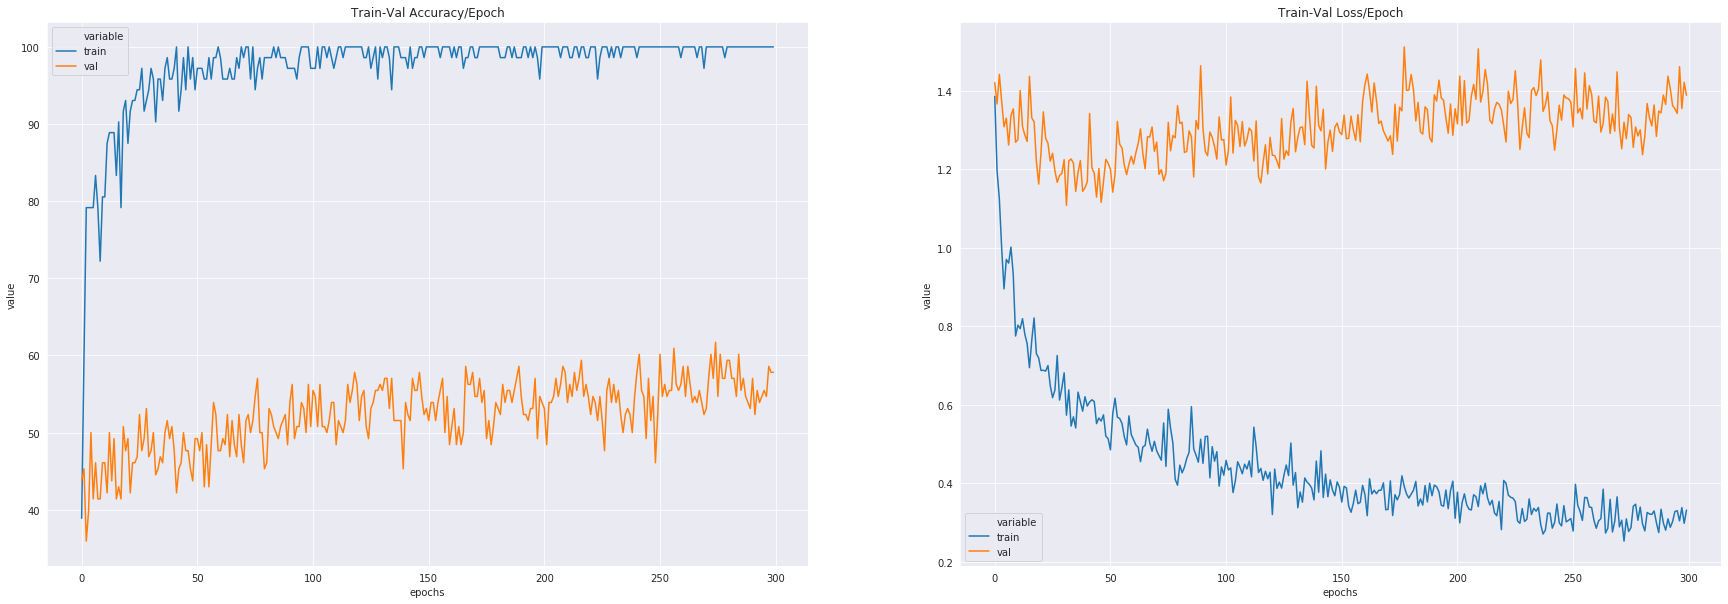

In [30]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30,10))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

As you can see, the val_loss starts increasing after around 10 epochs while the train loss keeps decreasing. This means that your model has started to overfit. You can retrain this model to train for ~10 epochs to prevent overfitting. However, I've noticed if I do that, the test F1 score remains around 50% while with this config, it's at 60%. 

## Test

After training is done, we need to test how our model fared. Note that we've used model.eval() before we run our testing code.   
To tell PyTorch that we do not want to perform back-propagation during inference, we use torch.no_grad() , just like we did it for the validation loop above.

* We start by defining a list that will hold our predictions. Then we loop through our batches using the test_loader. For each batch -
* We move our input mini-batch to GPU.
* We make the predictions using our trained model.
* Apply log_softmax activation to the predictions and pick the index of highest probability.
* Move the batch to the GPU from the CPU.
* Convert the tensor to a numpy object and append it to our list.
* Flatten out the list so that we can use it as an input to confusion_matrix and classification_report .

In [31]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
        _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())

In [32]:
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

### Confusion Matrix

We create a dataframe from the confusion matrix and plot it as a heatmap using the seaborn library.

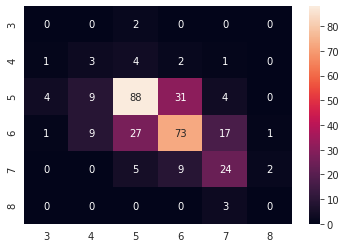

In [33]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

### Classification Report

Finally, we print out the classification report which contains the precision, recall, and the F1 score.

In [34]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.14      0.27      0.19        11
           2       0.70      0.65      0.67       136
           3       0.63      0.57      0.60       128
           4       0.49      0.60      0.54        40
           5       0.00      0.00      0.00         3

    accuracy                           0.59       320
   macro avg       0.33      0.35      0.33       320
weighted avg       0.62      0.59      0.60       320

